In [147]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

from utils import decorate
from thinkstats2 import Pmf, Cdf

import thinkstats2
import thinkplot

In [148]:
df = pandas.read_stata('nsch_2017_topical.dta')

***
# 2017 NSCH Data

**Code book:** https://www.census.gov/data-tools/demo/nsch/#/?s_searchvalue=age&s_year=2017&selectedVar=A1_AGE

**Article:** http://time.com/5437607/smartphones-teens-mental-health/

`k7q91_r`: How Much Time Spent with Computers

`k7q60_r`: How Much Time Spent Watching TV

**Response Codes:**
- 1 = None
- 2 = Less than 1 hour
- 3 = 1 hour
- 4 = 2 hours
- 5 = 3 hours
- 6 = 4 or more hours

In [149]:
df['cmputr_time'] = df.k7q91_r.copy() - 1
df.cmputr_time.head()

0    0.0
1    3.0
2    3.0
3    4.0
4    1.0
Name: cmputr_time, dtype: float64

In [150]:
df['tv_time'] = df.k7q60_r.copy() - 1
df.tv_time.head()

0    0.0
1    2.0
2    1.0
3    4.0
4    2.0
Name: tv_time, dtype: float64

`sc_age_years`: Age of Selected Child - In Years (0 - 17)

In [151]:
df.sc_age_years.head()

0     0
1    13
2    15
3     9
4     8
Name: sc_age_years, dtype: int8

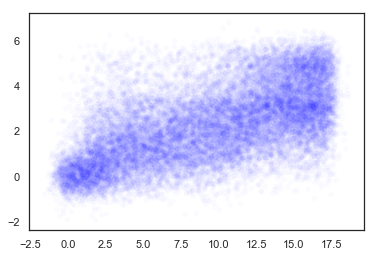

In [217]:
# Jitter plot
x = thinkstats2.Jitter(df.sc_age_years, 0.5)
y1 = thinkstats2.Jitter(df.cmputr_time, 0.5)
thinkplot.Scatter(x, y1, alpha=0.02)

In [196]:
# Group them into income level bins
bins = np.arange(df.sc_age_years.min(), df.sc_age_years.max() + 1, 1)
indices = np.digitize(df.sc_age_years, bins)
groups = df.groupby(indices)

cmputr_time = [group.cmputr_time.mean() for i, group in groups]
tv_time = [group.tv_time.mean() for i, group in groups]
total_time = [group.cmputr_time.mean() + group.tv_time.mean() for i, group in groups]

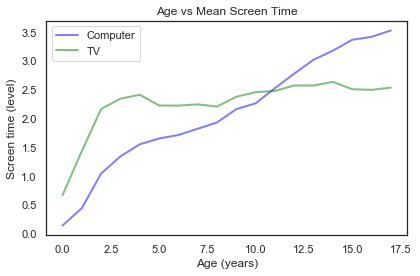

In [200]:
plt.plot(bins, cmputr_time, label='Computer', linewidth=2, color='blue', alpha=0.5)
plt.plot(bins, tv_time, label='TV', linewidth=2, color='green', alpha=0.5)
plt.legend(loc='best')
decorate(title='Age vs Mean Screen Time', xlabel='Age (years)', ylabel='Screen time (level)')

In [208]:
# Group them into income level bins
def group_to_bins(dataSeries):
    bins = np.arange(dataSeries.min(), dataSeries.max() + 1, 1)
    indices = np.digitize(dataSeries, bins)
    groups = df.groupby(indices)

    perc_1 = []
    perc_2 = []
    for i, group in groups:
        count = count_2 = 0
        total = group.k4q22_r.dropna().count()
        for value in group.k4q22_r:
            if (value == 1):
                count += 1
            if (value == 2):
                count_2 += 1
        perc_1.append(count/total*100)
        perc_2.append((count + count_2)/total*100)
    return bins, perc_1, perc_2

bins, perc_1, perc_2 = group_to_bins(df.cmputr_time)
bins_tv, perc_1_tv, perc_2_tv = group_to_bins(df.tv_time)

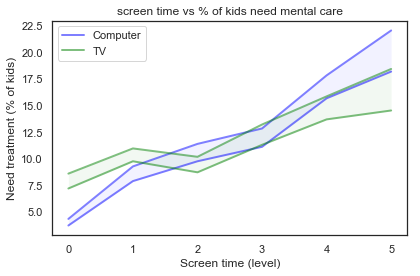

In [209]:
fig, ax = plt.subplots()
# Computer time
ax.plot(bins, perc_1, label='Computer', linewidth=2, color='blue', alpha=0.5)
ax.plot(bins, perc_2, linewidth=2, color='blue', alpha=0.5)
ax.fill_between(bins, perc_1, perc_2, where=perc_2 >= perc_1, facecolor='blue', alpha=0.05, interpolate=True)
# TV time
ax.plot(bins_tv, perc_1_tv, label='TV', linewidth=2, color='green', alpha=0.5)
ax.plot(bins_tv, perc_2_tv, linewidth=2, color='green', alpha=0.5)
ax.fill_between(bins_tv, perc_1_tv, perc_2_tv, where=perc_2_tv >= perc_1_tv, facecolor='green', alpha=0.05, interpolate=True)
plt.legend(loc='best')
decorate(title='screen time vs % of kids need mental care', xlabel='Screen time (level)', ylabel='Need treatment (% of kids)')